In [17]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import sys
from pathlib import Path
import datetime
import lab.torch as B
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from wbml import plot
import tueplots
from collections import defaultdict
torch.set_printoptions(profile='full') # 'short'

colors = sns.color_palette("bright")
sns.set_style("whitegrid")
sns.set_palette(colors)


from tueplots import bundles, fontsizes, figsizes
plt.rcParams.update({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()})
matplotlib.rcParams["figure.dpi"] = 300  # for high quality, retina plots


from wbml import plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Locations

In [18]:
img_folder = 'tmp'

In [37]:
include_adult = {}

In [119]:
include_bank = {
    # GVI
    # "results_newer/Bank/A/GVI/08-04-04.49.06_seq-gi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p",
    # "results_newer/Bank/A/GVI/08-04-04.24.43_seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p",
    
    # "results_newer/Bank/A/GVI/08-04-18.55.32_seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-100p",
    # "results_newer/Bank/A/GVI/08-04-20.44.41_seq-gi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-10m-100p",

    # "results_newer/Bank/A/GVI/08-04-09.28.52_seq-mfvi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p",
    # "results_newer/Bank/A/GVI/08-04-09.28.44_seq-mfvi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-20p",

    "results_newer/Bank/A/GVI/08-06-08.31.47_seq-gi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Bank/A/GVI/08-06-08.32.55_seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Bank/A/GVI/08-06-12.08.54_seq-mfvi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p",
    "results_newer/Bank/A/GVI/08-06-12.09.20_seq-mfvi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-20p",

    # Seq
    "results_newer/Bank/A/Seq/08-04-01.47.16_seq-gi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Bank/A/Seq/08-04-01.51.34_seq-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Bank/A/Seq/08-04-13.42.19_seq-mfvi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-20p",
    "results_newer/Bank/A/Seq/08-04-09.30.36_seq-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p",

    # Sync
    "results_newer/Bank/A/Sync/08-05-22.11.06_sync-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Bank/A/Sync/08-05-22.14.31_sync-mfvi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-damp-0-2-20p", 
    "results_newer/Bank/A/Sync/08-05-22.27.03_sync-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-damp-0-2-20p",
}

In [120]:
########### READ LOG FILES ###########

main_dir = os.path.dirname(os.path.abspath(os.getcwd()))
res = "results_newer/"
res_dir = os.path.join(main_dir, res)

infinite_defaultdict = lambda: defaultdict(infinite_defaultdict)
logs = infinite_defaultdict()

# Column headers
pvi_name = "PVI"
variational_name = "Method"
client_name = "Client"
split_name = "Split"
dataset_name = 'Dataset'
experiment_name ='Experiment name'
num_clients_name = 'Number of clients'
prior_name = 'Prior'

for dataset_type in os.listdir(res_dir):
    if dataset_type in ["Adult", "Bank", "Credit"]:
        for split_type in os.listdir(os.path.join(res_dir, dataset_type)):
            for pvi_type in os.listdir(os.path.join(res_dir, dataset_type, split_type)):
                
                exp_dir = os.path.join(res_dir, dataset_type, split_type, pvi_type)

                for exp in os.listdir(exp_dir):
                    q_type = exp.split('_')[1].split('-')[1]
                    num_clients = int(exp.split('_')[1].split('-')[3].split('c')[0])
                    # Erroneous file naming
                    if q_type == 'pvi': q_type = 'gi'
                    
                    metrics_dir = os.path.join(exp_dir, exp, "metrics")
                    _exp_name = '-'.join(exp.split('_')[1:])
                    prior_type = 'Std' if 'std' in _exp_name else 'Neal'

                    # Exclude experiments in array
                    x = os.path.join(res, dataset_type, split_type, pvi_type, exp)
                    if x in include_adult or x in include_bank:
                        
                        current_df = logs[dataset_type][pvi_type][split_type][q_type][prior_type]

                        # Existing log file
                        if type(current_df[experiment_name]) == str:
                            # OVERWRITE EXISTING LOG FILE
                            print(f"{dataset_type}/{pvi_type}/{split_type}/{q_type}/{prior_type}: {current_df[experiment_name]} ==> {_exp_name}")
                        else:
                            print(f"{dataset_type}/{pvi_type}/{split_type}/{q_type}/{prior_type} = {_exp_name}")

                        # Set logs[...] to current experiment
                        current_df[experiment_name] = _exp_name
                        
                        # Load metrics
                        for log_name in os.listdir(metrics_dir):
                            name = log_name.split('_')[0]
                            
                            current_df[name] = pd.read_csv(os.path.join(metrics_dir, log_name))

                            # Add column values
                            current_df[name][pvi_name] = pvi_type.upper()
                            current_df[name][variational_name] = q_type.upper()
                            current_df[name][split_name] = split_type.upper()
                            current_df[name][dataset_name] = dataset_type
                            current_df[name][prior_name] = prior_type
                            if name != 'server':
                                current_df[name][client_name] = name
                            current_df[name][num_clients_name] = num_clients
                            current_df[name][experiment_name] = _exp_name

Bank/Seq/A/mfvi/Neal = seq-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p
Bank/Seq/A/mfvi/Std = seq-mfvi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-20p
Bank/Seq/A/gi/Std = seq-gi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p
Bank/Seq/A/gi/Neal = seq-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p
Bank/GVI/A/gi/Neal = seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p
Bank/GVI/A/mfvi/Neal = seq-mfvi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p
Bank/GVI/A/gi/Std = seq-gi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p
Bank/GVI/A/mfvi/Std = seq-mfvi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-20p
Bank/Sync/A/gi/Neal = sync-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p
Bank/Sync/A/mfvi/Std = sync-mfvi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-damp-0-2-20p
Bank/Sync/A/mfvi/Neal = sync-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-damp-0-2-20p


Merge dataframes for plotting purposes.

In [121]:
clients = []
for dataset, d in logs.items():
    for pvi_setting, dd in d.items():
        for split_setting, ddd in dd.items():
            for q_setting, dddd in ddd.items():
                for prior_setting, ddddd in dddd.items():
                    for name, log in ddddd.items():
                        if name != experiment_name and name != 'server': clients.append(log)

client = pd.concat(clients, ignore_index=True)

In [122]:
servers = []

for dataset, d in logs.items():
    for pvi_setting, dd in d.items():
        for split_setting, ddd in dd.items():
            for q_setting, dddd in ddd.items():
                for prior_setting, ddddd in dddd.items():
                    for name, log in ddddd.items():
                        if name != experiment_name and name == 'server': servers.append(log)

server = pd.concat(servers, ignore_index=True)

In [123]:
server.groupby(by=[dataset_name, split_name, pvi_name, split_name, variational_name, experiment_name]).size()

Dataset  Split  PVI   Split  Method  Experiment name                                                                 
Bank     A      GVI   A      GI      seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                        11
                                     seq-gi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p                         11
                             MFVI    seq-mfvi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p                11
                                     seq-mfvi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-20p                 11
                SEQ   A      GI      seq-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                      101
                                     seq-gi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p                       101
                             MFVI    seq-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p               88
       

In [124]:
server.groupby(by=[variational_name, dataset_name, split_name, pvi_name, split_name, variational_name, experiment_name]).size()

Method  Dataset  Split  PVI   Split  Method  Experiment name                                                                 
GI      Bank     A      GVI   A      GI      seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                        11
                                             seq-gi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p                         11
                        SEQ   A      GI      seq-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                      101
                                             seq-gi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p                       101
                        SYNC  A      GI      sync-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                      11
MFVI    Bank     A      GVI   A      MFVI    seq-mfvi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p                11
                                             seq-mfvi-bank-1c-10g-10000l-std

# Plotting

test mll

In [125]:
dataset = "Bank"
split = "A"
omit_sync_mfvi = False
save_plot = True

data = server.loc[server[split_name] == split]
data = data.loc[data[dataset_name] == dataset]
# data = data.loc[data[pvi_name] != 'SYNC']
data = data.loc[data[prior_name] == 'Neal']

if omit_sync_mfvi:
    data = data.loc[~((data[pvi_name] == 'SYNC') & (data[variational_name] == 'MFVI'))]

data = data.sort_values(by=[variational_name, split_name, dataset_name, prior_name, experiment_name, 'communications'])

append_file_name = ""

# Check whether these are the experiments you want to plot.
data.groupby(by=[variational_name, dataset_name, split_name, prior_name, experiment_name]).size()

Method  Dataset  Split  Prior  Experiment name                                                                 
GI      Bank     A      Neal   seq-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                      101
                               seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                        11
                               sync-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                      11
MFVI    Bank     A      Neal   seq-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p               88
                               seq-mfvi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p                11
                               sync-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-damp-0-2-20p     11
dtype: int64

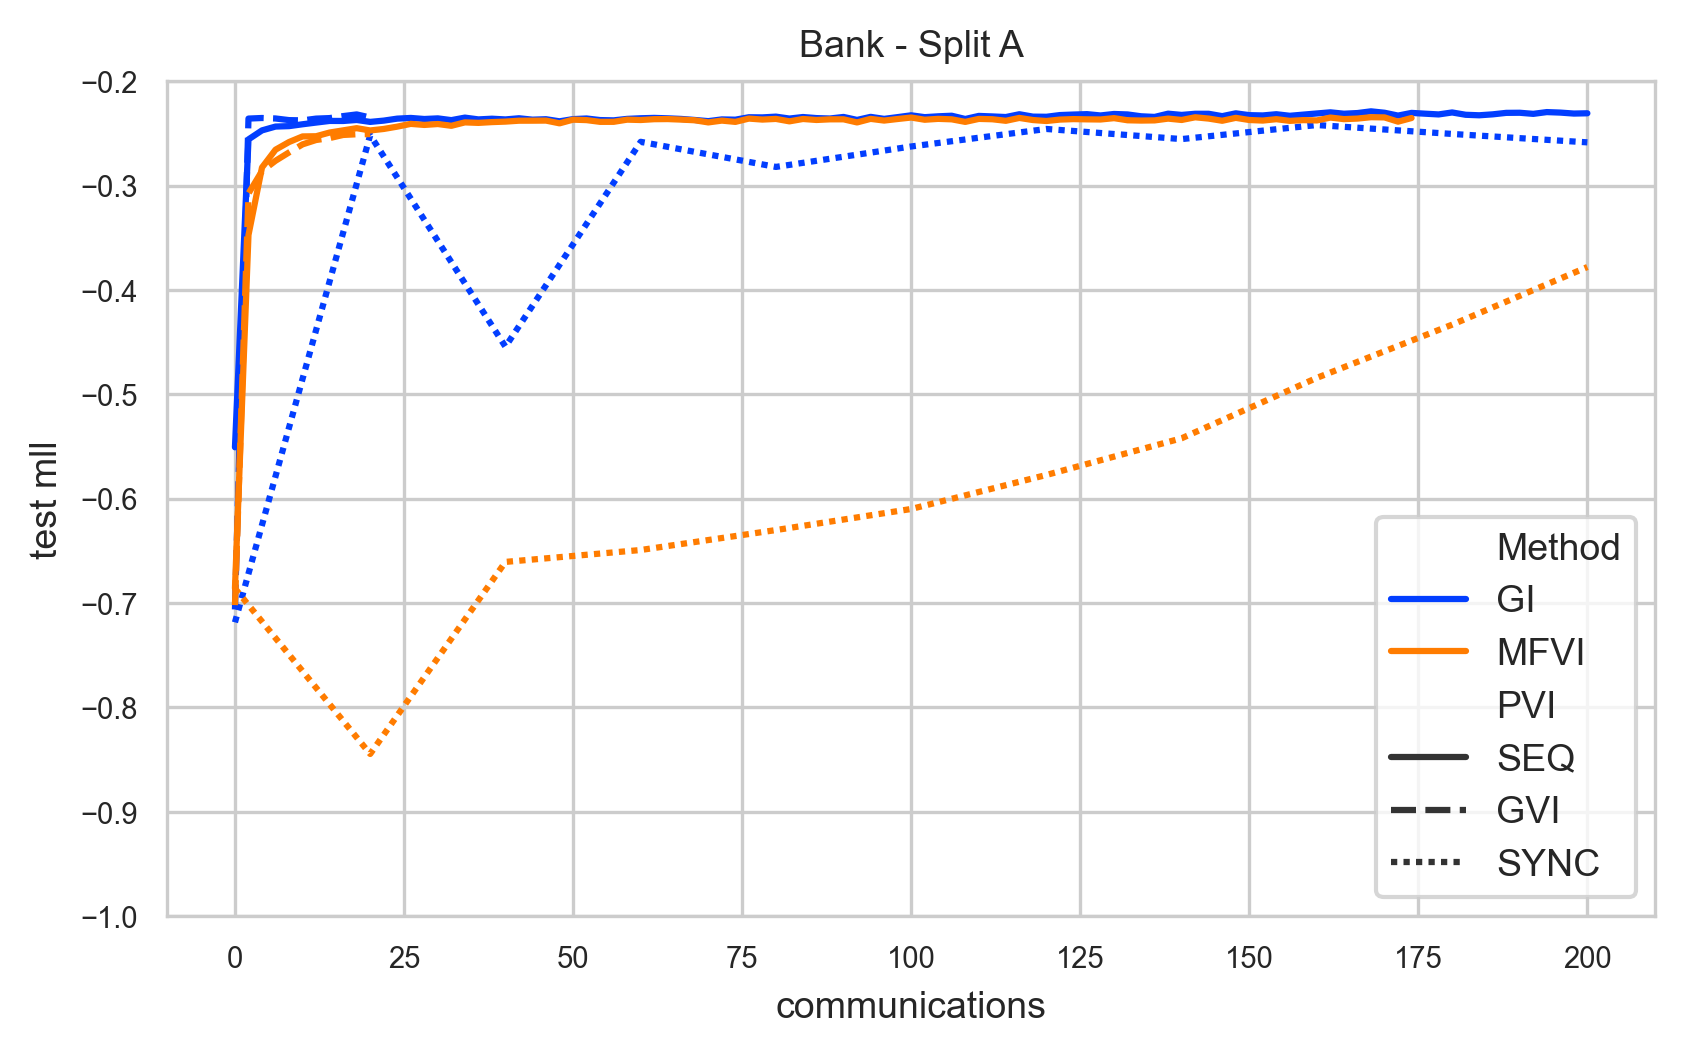

Method  Dataset  Split  Prior  Experiment name                                                                 
GI      Bank     A      Neal   seq-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                      101
                               seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                        11
                               sync-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                      11
MFVI    Bank     A      Neal   seq-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p               88
                               seq-mfvi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p                11
                               sync-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-damp-0-2-20p     11
dtype: int64


In [126]:
_start = datetime.datetime.utcnow()
_time = _start.strftime("%m-%d-%H-%M")

with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)

    x_metric = 'communications'
    y_metric = 'test_mll'
    
    # sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, hue=variational_name, style=pvi_name, size=prior_name)
    sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, hue=variational_name, style=pvi_name)
    
    ax.set_ylim(-1., -0.2)
    # ax.set_ylim(.86, .91)
    # ax.set_xlim(0, 25)
    ax.set_title(f'{dataset} - Split {split}')
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    file_name = f"./{img_folder}/{dataset}_{split}_{_time}_server_{x_metric}_{y_metric}"
    # if omit_sync_mfvi: file_name += "_omit_sync_mfvi"

    file_name += append_file_name
    if save_plot: plt.savefig(file_name)
    plt.show()

print(data.groupby(by=[variational_name, dataset_name, split_name, prior_name, experiment_name]).size())

### Client

In [70]:
client.columns

Index(['global_iteration', 'local_iteration', 'total_iteration', 'vfe', 'll',
       'kl', 'error', 'PVI', 'Method', 'Split', 'Dataset', 'Prior', 'Client',
       'Number of clients', 'Experiment name'],
      dtype='object')

In [100]:
dataset = "Bank"
split = "A"
omit_sync_mfvi = True
save_plot = True

data = client.loc[client[split_name] == split]
data = data.loc[data[dataset_name] == dataset]
data = data.loc[data[pvi_name] != 'SYNC']
data = data.loc[data[prior_name] == 'Neal']
data = data.loc[data['Client'] == "client0"]

if omit_sync_mfvi:
    data = data.loc[~((data[pvi_name] == 'SYNC') & (data[variational_name] == 'MFVI'))]

data = data.sort_values(by=[variational_name, split_name, dataset_name, experiment_name, 'total_iteration'])

# Check whether these are the experiments you want to plot.
print(data.groupby(by=[variational_name, dataset_name, split_name, prior_name, experiment_name]).size())

Method  Dataset  Split  Prior  Experiment name                                                       
GI      Bank     A      Neal   seq-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p            537
                               seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p             653
MFVI    Bank     A      Neal   seq-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p    437
                               seq-mfvi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p     618
dtype: int64


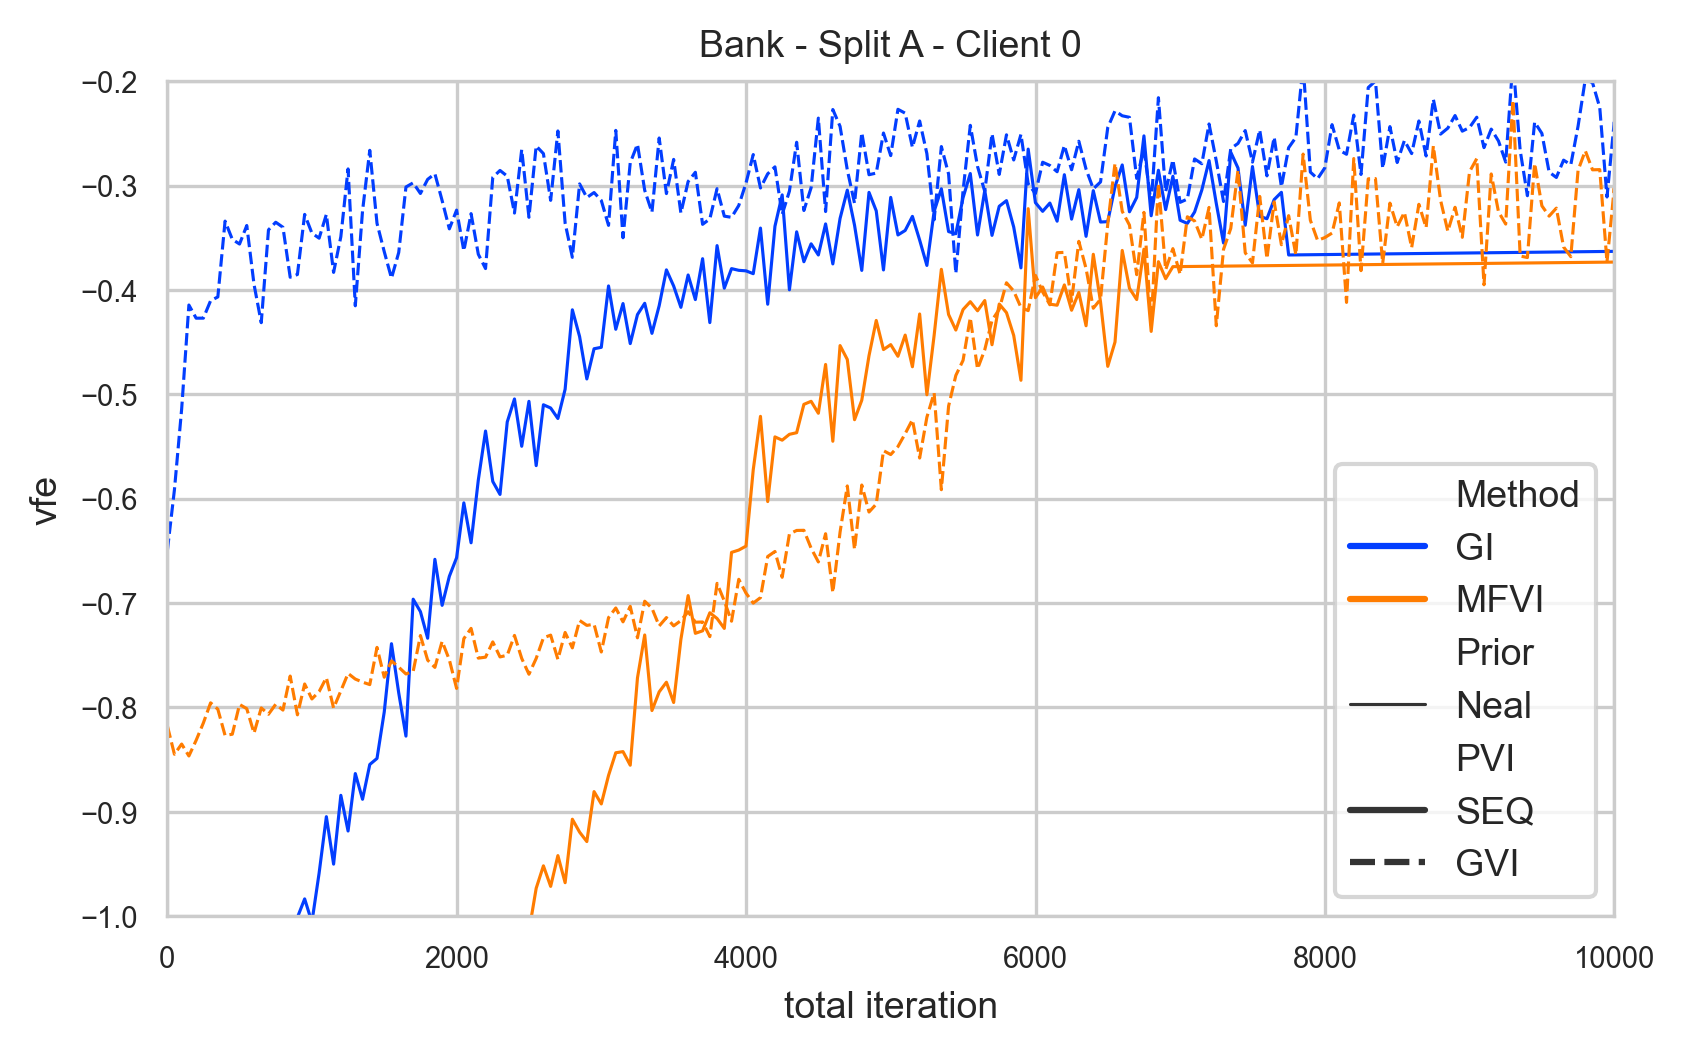

Method  Dataset  Split  Prior  Experiment name                                                       
GI      Bank     A      Neal   seq-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p            537
                               seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p             653
MFVI    Bank     A      Neal   seq-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p    437
                               seq-mfvi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p     618
dtype: int64


In [102]:
_start = datetime.datetime.utcnow()
_time = _start.strftime("%m-%d-%H-%M")
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)
    
    y_metric = "vfe"
    x_metric = "total_iteration"
    
    sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, size=prior_name, hue=variational_name, style=pvi_name)
    
    ax.set_title(f'{dataset} - Split {split} - Client 0')
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    ax.set_ylim(-1.0, -0.2)
    ax.set_xlim(0, 1e4)

    file_name = f"./{img_folder}/{dataset}_{split}_{_time}_client_{x_metric}_{y_metric}"
    if omit_sync_mfvi: file_name += "_omit_sync_mfvi"

    if save_plot: plt.savefig(file_name)
    plt.show()

print(data.groupby(by=[variational_name, dataset_name, split_name, prior_name, experiment_name]).size())